In [1]:
import sim          # Library for coppelia communication       
import sympy as sp  # Library to work with symbolic variables
from scipy import optimize
import numpy as np
import time
from matplotlib import pyplot as plt

In [2]:
# Function to calculate symbolic denavit transformations from parameters

def symTfromDH(theta, d, a, alpha):

    Rz = sp.Matrix([[sp.cos(theta), -sp.sin(theta), 0, 0],
                   [sp.sin(theta), sp.cos(theta), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    tz = sp.Matrix([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 1, d],
                   [0, 0, 0, 1]])
    ta = sp.Matrix([[1, 0, 0, a],
                   [0, 1, 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    Rx = sp.Matrix([[1, 0, 0, 0],
                   [0, sp.cos(alpha), -sp.sin(alpha), 0],
                   [0, sp.sin(alpha), sp.cos(alpha), 0],
                   [0, 0, 0, 1]])
    T = Rz*tz*ta*Rx
    return T

## Calculate Denavit Transformations

In [3]:
# Robot dimensions
L3 = 1.5
L4 = 1
L5 = 0.5

q1 = sp.symbols('q1') # First rotational joint angle
q2 = sp.symbols('q2') # Second rotational joint angle
l1 = sp.symbols('l1') # First prismatic joint length
l2 = sp.symbols('l2') # Second prismatic joint length

# Calculated denavit parameters
theta = [sp.pi/2,-sp.pi/2, 0 , q1 ,q2]
d = [L3,l1,l2,0,0]
a = [0,0,0,L4,L5]
alpha = [sp.pi/2,-sp.pi/2,0,0,0]

# Partial transformations to end effector
T01 = symTfromDH(theta[0],d[0],a[0],alpha[0])
T12 = symTfromDH(theta[1],d[1],a[1],alpha[1])
T23 = symTfromDH(theta[2],d[2],a[2],alpha[2])
T34 = symTfromDH(theta[3],d[3],a[3],alpha[3])
T45 = symTfromDH(theta[4],d[4],a[4],alpha[4])

# Final tranformation
T05 = T01*T12*T23*T34*T45
T05.simplify()
T05

Matrix([
[-sin(q1 + q2), -cos(q1 + q2), 0, 1.0*l1 - 1.0*sin(q1) - 0.5*sin(q1 + q2)],
[            0,             0, 1,                                      l2],
[-cos(q1 + q2),  sin(q1 + q2), 0,   -1.0*cos(q1) - 0.5*cos(q1 + q2) + 1.5],
[            0,             0, 0,                                       1]])

## Direct Kinematics

In [4]:
# Evaluate end effector transformation
values ={      # Limits
q1:0,           # (0-2pi)
q2:1.159,     # (-pi/2,pi/2)
l1:1.158,           # (0,3m)
l2:0.4           # (0,2m)
}

T05.evalf(subs=values)


Matrix([
[-0.916403310907401, -0.400256132692496,   0, 0.699798344546299],
[                 0,                  0, 1.0,               0.4],
[-0.400256132692496,  0.916403310907401,   0, 0.299871933653752],
[                 0,                  0,   0,               1.0]])

In [7]:
# Evaluate random positions to plot the work volume
N_POINTS = 10000
points = np.zeros([N_POINTS,3])
for i in range(N_POINTS):
    values ={     
    q1:np.random.uniform(0,2*sp.pi),   # (0-2pi)     
    q2:np.random.uniform(-sp.pi/2,sp.pi/24),   # (-pi/2,pi/2)
    l1:np.random.uniform(0,3),           # (0,3m)
    l2:np.random.uniform(0,2),           # (0,2m)
    }
    points[i,0:3] = (np.array(T05.evalf(subs=values)[0:3,3]).squeeze())

Text(0.5, 0, 'z')

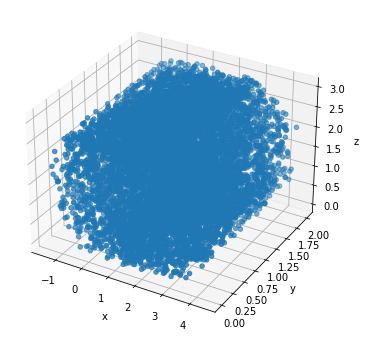

In [22]:
#import mpld3
#mpld3.enable_notebook()
#%matplotlib notebook
plt.rcParams['figure.figsize'] = (8,6)
ax =plt.axes(projection='3d')

ax.scatter3D(points[:,0],points[:,1],points[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.view_init(elev=00,azim=0)


In [33]:
# Function to connect to coppelia simulator

def connect(port):
    sim.simxFinish(-1) # just in case, close all opened connections
    clientID=sim.simxStart('127.0.0.1',port,True,True,2000,5)
    if clientID == 0: print("conectado a", port)
    else: print("no se pudo conectar")
    return clientID

In [168]:
# Connection to coppelia 
clientID = connect(25000)
# Get joints and end effector handlers
retCode,pjoint0=sim.simxGetObjectHandle(clientID,'pjoint0',sim.simx_opmode_blocking) 
retCode,pjoint1=sim.simxGetObjectHandle(clientID,'pjoint1',sim.simx_opmode_blocking) 
retCode,rjoint0=sim.simxGetObjectHandle(clientID,'rjoint0',sim.simx_opmode_blocking) 
retCode,rjoint1=sim.simxGetObjectHandle(clientID,'rjoint1',sim.simx_opmode_blocking) 
retCode,end_effector=sim.simxGetObjectHandle(clientID,'EndEffector',sim.simx_opmode_blocking) 

# Read end effector actual position
returnCode,ef_pos = sim.simxGetObjectPosition(clientID,end_effector,-1,sim.simx_opmode_blocking) # Read tip position relative to base(-1) in meters
print([ef_pos])

conectado a 25000
[[1.499999761581421, 1.0000026226043701, 0.5000006556510925]]


In [171]:
# Send new values for joints
q1 = -0.4
q2 = 1.4
l1 = 0.3
l2 = 0.5
retCode = sim.simxSetJointTargetPosition(clientID,pjoint0,l1, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID,pjoint1,l2, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID,rjoint0,q1, sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID,rjoint1,q2, sim.simx_opmode_oneshot)
time.sleep(2)
# Read new end effector position
returnCode,ef_pos = sim.simxGetObjectPosition(clientID,end_effector,-1,sim.simx_opmode_blocking) # Read tip position relative to base(-1) in meters
print([ef_pos])

[[0.26499053835868835, 0.5000028014183044, 0.30887681245803833]]


## Inverse Kinematics

In [178]:
T05

Matrix([
[-sin(q1 + q2), -cos(q1 + q2), 0, 1.0*l1 - 1.0*sin(q1) - 0.5*sin(q1 + q2)],
[            0,             0, 1,                                      l2],
[-cos(q1 + q2),  sin(q1 + q2), 0,   -1.0*cos(q1) - 0.5*cos(q1 + q2) + 1.5],
[            0,             0, 0,                                       1]])

In [181]:
# Define end effector postition

X = 0.7
Y = 0.4
Z = 0.3

def eqs(q):
    q1 = q[0]
    q2 = q[1]
    l1 = q[2]
    l2 = q[3]
    f = np.zeros(4)
    # Position Equations to solve
    f[0] = l1-np.sin(q1) - 0.5*np.sin(q1+q2) - X
    f[1] = l2 - Y
    f[2] = -np.cos(q1) - 0.5*np.cos(q1+q2) + 1.5 - Z
    # 
    f[3] = q1
    return f


In [185]:
q=optimize.fsolve(eqs,[1,1,1,1])
print(f'q1 : {q[0]} , q2 : {q[1]} , l1 : {q[2]} , l2 : {q[3]}')

q1 : -2.313059664826635e-24 , q2 : 1.1592794807216733 , l1 : 1.1582575694714008 , l2 : 0.4


In [ ]:
# Move robot to newly claculated position

retCode = sim.simxSetJointTargetPosition(clientID, rjoint1,q[0], sim.simx_opmode_blocking)
retCode = sim.simxSetJointTargetPosition(clientID, rjoint0,q[1], sim.simx_opmode_blocking)
retCode = sim.simxSetJointTargetPosition(clientID, pjoint0,q[2], sim.simx_opmode_blocking)
retCode = sim.simxSetJointTargetPosition(clientID, pjoint1,q[3], sim.simx_opmode_blocking)